# Landsat 8 and Modis Data Download & Preprocessing

The goal of this project is to gather, analyze, and predict the prevalence of water hyacinth in the Winam Gulf of Lake Victoria from 1984 to 2022. The data will be used to create the _Hyatrak Predictor©_ , a model that forecasts the growth of the invasive plant, which will help with sustainable harvesting for the production of biofuels and other biorenewables. The project is intended to serve as a pilot, with the potential to be scaled to other regions affected by excessive water hyacinth encroachment.

This notebook shows you how to use GeoPandas and Google Earth Engine to:

1. Download Modis and Landsat 8 data
2. Download and use CHIRPS dataset
3. Calculate NDVI, NDBI and NDWI
4. Perfrom area (km²) calculation

## Installation

In [ ]:
!pip -q install geopandas
!pip -q install geojson
!pip -q install --upgrade folium
!pip -q install -U geemap
!pip -q install rasterio
!pip -q install tqdm

!apt install libspatialindex-dev
!pip -q install rtree
!pip -q install eeconvert
#!pip -q uninstall tornado
!pip -q install tornado==5.1.0 # to ensure geemap gets installed
!pip -q install urllib3



## Imports & Setup

In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import geojson
import requests

import rasterio as rio
from rasterio.plot import show
import rasterio.mask
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon


from rasterio import windows
from shapely.geometry import box
import pandas as pd

import ee
import geemap
import geemap.eefolium as emap



## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Authenticate Google Earth Engine

In [ ]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=yplsFV7t_L313osC6ZaNhhXruOZwUQ0EThTsbt55bAw&tc=BRaz37tXKW-nnES2eOrtcJ_Ug5UrDMXdo8hip46W0sI&cc=GZjDL6G85LKnw5LXYo1T4ZJe74BoX92u8gzfW35QlQ4

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1ARtbsJrSDhCrADDrQMxbBcmeC0Jf5dRKOSaS6_a2VB9uqBPdL8oXMpTHZJU

Successfully saved authorization token.


## Fetch AOI from google drive...hopefully you had earlier saved it

In [ ]:

winam_lake_path= './drive/My Drive/side gig/Hyacinth_eric/Winam_lake.geojson'
winam_without_lake_path='./drive/My Drive/side gig/Hyacinth_eric/Winam_buffer_minus_lake.geojson'


## Visualize the Area of Interest (AOI)
The Area of interest is the Winam Gulf of Lake Victoria, containing 2 sampling points: 
1. Kisumu city  - Densely populated, urban demographic
2. Homa-bay town - Moderately populated, peri-urban/rural demographic

In [ ]:

##load the geojson

winam_lake=gpd.read_file(winam_lake_path)
winam_without_lake=gpd.read_file(winam_without_lake_path)
winam_with_lake.head(3)

,LAKE,ETYPE,layer,path,geometry
0,Lake Victoria,None,L_Victoria_Arc1960_utm37s_split,D:/PROJECTS/Humburg_Lake_Victoria/vector data/...,"MULTIPOLYGON (((34.10897 -0.54130, 34.12196 -0..."


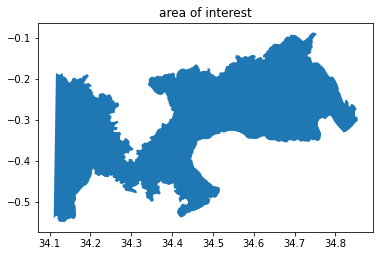

In [ ]:
#Visualize the AOI

winam_lake.plot()
plt.title("area of interest")
plt.show()


In [ ]:
#identify the centre coordinates of the data. Will help in visualization
centre_x=winam_without_lake["geometry"][0].centroid.x
centre_y=winam_without_lake["geometry"][0].centroid.y
centroid=[centre_x,centre_y]


In [ ]:
#identify the geomety enclosing our dataset. the imagery will be clipped to this area of interest

#print(list(winam_with_lake_AOI["geometry"][0].exterior.coords))
winam_without_lake_geom=winam_without_lake["geometry"][0]
winam_lake_geom=winam_lake["geometry"][0]

#consists of a polygon in a multipolygon set up. get the polygon.
winam_without_lake_poly=winam_without_lake_geom[0]
winam_lake_poly=winam_lake_geom[0]

#get the outside coords
ext_coord_winam_without_lake=list(winam_without_lake_poly.exterior.coords)
ext_coord_winam_lake=list(winam_lake_poly.exterior.coords)

#generate an Earth Engine polygon of the input coordinates
geometry_winam_without_lake=ee.Geometry.Polygon(ext_coord_winam_without_lake)
true_geometry_winam_lake=ee.Geometry.Polygon(ext_coord_winam_lake)

'for the lake or any shapefile with intersecting or generally invalid geometry, gets ignored by GEE. better to use the bounding box in this case'
#minx=winam_lake.bounds['minx'].values[0]
#miny=winam_lake.bounds['miny'].values[0]
#maxx=winam_lake.bounds['maxx'].values[0]
#maxy=winam_lake.bounds['maxy'].values[0]
#geometry_winam_lake = ee.Geometry.Rectangle([minx,miny,maxx,maxy])


## Generate Landsat , Chirps and MODIS data using Google Earth Engine

**Note**: You'll need to sign up for access to Google Earth Engine at https://code.earthengine.google.com/. 

In [ ]:
"""


ID	Description
LT04	Landsat 4, Thematic Mapper (TM)  16th July 1982 to 14th December 1993  temp band: ST_B6  , red:SR_B3    ,nir:SR_B4  ,swir:SR_B5
LT05	Landsat 5, Thematic Mapper (TM)   1st March 1984 to 5th June 2013  temp band: ST_B6   , red: SR_B3   , nir:SR_B4  ,swir: SR_B5
LE07	Landsat 7, Enhanced Thematic Mapper Plus (ETM+) 15th 1999 to 6 April 2022  temp band: ST_B6  , red: SR_B3 , nir:SR_B4 ,swir:SR_B5
LC08	Landsat 8, Operational Land Imager (OLI) April 2013 to present   temp band: ST_B10,   red:SR_B4   ,nir: SR_B5 ,swir:SR_B6

"""

In [ ]:
# this function identifies relevant chirps, landsat and modis data and calculates montly statistics from them

def calculate_stats(year,duration_in_years,region_aoi,lake_aoi): 
  dict_month_year={"Year":[],"month":[],"mean_monthly_temp":[],"mean_monthly_rainfall":[],"littoral_mean_monthly_ndvi":[],"littoral_vegetation_area":[],"mean_monthly_ndbi":[],"Bare_soil_area":[],"mean_monthly_ndwi":[],"water_area":[],"hyacinth_mean_monthly_ndvi":[],"hyacinth_area":[]}  




  # year, month, date format
  for i in range(duration_in_years):
    current_year=year+i

    if current_year>=1983 and year<1994:
      landsat_sat="LANDSAT/LT04/C02/T1_L2"
      green_band='SR_B2'
      red_band='SR_B3'
      nir_band='SR_B4'
      swir_band='SR_B5'
      temp_band= 'ST_B6'
    if current_year>=1995 and year<1999:
      landsat_sat="LANDSAT/LT05/C02/T1_L2"
      green_band='SR_B2'
      red_band='SR_B3'
      nir_band='SR_B4'
      swir_band='SR_B5'
      temp_band= 'ST_B6'
    if current_year>=1999 and year<2022:
      landsat_sat='LANDSAT/LE07/C02/T1_L2'
      green_band='SR_B2'
      red_band='SR_B3'
      nir_band='SR_B4'
      swir_band='SR_B5' 
      temp_band='ST_B6'
    if current_year==2022:
      landsat_sat='LANDSAT/LC08/C02/T1_L2'
      green_band='SR_B3'
      red_band='SR_B4'
      nir_band='SR_B5'
      swir_band='SR_B6' 
      temp_band='ST_B10'





    for k in range(1,12+1):
      print("year {}, month {}".format(current_year,k))
      
      start_date="{}-{}-{}".format(year+i,k,1)
      end_date="{}-{}-{}".format(year+i,k,31)
    
      if k==2:
        start_date="{}-{}-{}".format(year+i,k,1)
        end_date="{}-{}-{}".format(year+i,k,28)

      if k==4 or k==6 or k==9 or k==11:
        start_date="{}-{}-{}".format(year+i,k,1)
        end_date="{}-{}-{}".format(year+i,k,30)

      

      def ndvi(aoi):
        try:
          landsat_band_image=ee.ImageCollection(landsat_sat).filterBounds(aoi).filterDate(start_date,end_date).mean()
          
          nir=landsat_band_image.select(nir_band)
          red=landsat_band_image.select(red_band)

          ndvi=nir.subtract(red).divide(nir.add(red)).rename('ndvi')

          ndvi_redu=ndvi.reduceRegion(reducer=ee.Reducer.mean(),geometry=aoi,scale=100,maxPixels=1e9)
          ndvi_val=round(ndvi_redu.get('ndvi').getInfo(), 2)

          #identify pixels whose value is greater than 0.1
          
          ndvi_greater_than_0_1=ndvi.gte(0.1).selfMask()
          ndvi_count=ndvi_greater_than_0_1.reduceRegion(reducer=ee.Reducer.count(),geometry=aoi,scale=100,maxPixels=1e9)
          ndvi_count=ndvi_count.get('ndvi').getInfo()
          ndvi_area=(ndvi_count*(30*30))/1000000# converting to km²

          print("ndvi count is", ndvi_count)
        except:
          ndvi_val=0
          ndvi_area=0

        return(ndvi_val,ndvi_area,ndvi)

        #####
      


      def satellite_modis(start_day,end_day):
        try:
         lst_modis = ee.ImageCollection('MODIS/006/MOD11A2').filterDate(start_day,end_day).select('LST_Day_1km').filterBounds(region_aoi)
         lst_img_modis = lst_modis.mean()
               
         lst_img_modis = lst_img_modis.select('LST_Day_1km').multiply(0.02) #scale the Modis image
         lst_img_modis = lst_img_modis.select('LST_Day_1km').add(-273.15).clip(region_aoi)
  
         meanDictionary_modis = lst_img.reduceRegion(reducer=ee.Reducer.mean(),geometry=region_aoi,scale=1000,maxPixels=1e9)
         monthly_values=round(meanDictionary_modis.get('LST_Day_1km').getInfo(), 2)
        
        except:
          monthly_values=0

        return monthly_values
      
        
      try: 

        lst = ee.ImageCollection(landsat_sat).filterDate(start_date,end_date).select(temp_band).filterBounds(region_aoi) 
         
        lst_img = lst.mean()
        lst_img = lst_img.select(temp_band).multiply(0.00341802).add(149.0) #scale the Landsat image
        lst_img = lst_img.select(temp_band).add(-273.15).clip(region_aoi)#.convert to degree Celcius

        meanDictionary_landsat = lst_img.reduceRegion(reducer=ee.Reducer.mean(),geometry=region_aoi,scale=100,maxPixels=1e9)
         
        monthly_values=round(meanDictionary_landsat.get(temp_band).getInfo())
 
      except:
        monthly_values=satellite_modis(start_date,end_date)
         
      try:
        rain = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').filter(ee.Filter.date(start_date,end_date)).select("precipitation").filterBounds(region_aoi)
        rain_img = rain.mean()

        meanDictionary_rain = rain_img.reduceRegion(reducer=ee.Reducer.mean(),geometry=region_aoi,scale=100,maxPixels=1e9)
        monthly_values_rain=round(meanDictionary_rain.get('precipitation').getInfo(), 2)
          
      except:
        monthly_values_rain=0

      #NDVI
      ndvi_val_adjacent_land,ndvi_area_adjacent_land,ndvi_adjacent_land=ndvi(region_aoi)

        #####


      #NDBI
      try:
        landsat_band_image=ee.ImageCollection(landsat_sat).filterBounds(region_aoi).filterDate(start_date,end_date).mean()
          
        nir=landsat_band_image.select(nir_band)
        swir1=landsat_band_image.select(swir_band)

        ndbi=swir1.subtract(nir).divide(swir1.add(nir)).rename("ndbi")

        ndbi_redu=ndbi.reduceRegion(reducer=ee.Reducer.mean(),geometry=region_aoi,scale=100,maxPixels=1e9)
        ndbi_val=round(ndbi_redu.get('ndbi').getInfo(), 2)

        #identify pixels whose value is greater than 0
        ndbi_greater_than_0=ndbi.gte(0).selfMask()
        ndbi_count=ndbi_greater_than_0.reduceRegion(reducer=ee.Reducer.count(),geometry=geometry_winam_with_lake,scale=100,maxPixels=1e9)
          
        ndbi_count=ndbi_count.get('ndbi').getInfo()
        print("ndbi_count",ndbi_count)
        ndbi_area=(ndbi_count*(30*30))/1000000# converting to km²
          
      except:
          ndbi_val=0
          ndbi_area=0

        #####
        
      #NDWI
      try:

        landsat_band_image=ee.ImageCollection(landsat_sat).filterBounds(lake_aoi).filterDate(start_date,end_date).mean()
            
        nir=landsat_band_image.select(nir_band)
        green=landsat_band_image.select(green_band)

        ndwi=green.subtract(nir).divide(green.add(nir)).rename("ndwi")
        
        ndwi_redu=ndwi.reduceRegion(reducer=ee.Reducer.mean(),geometry=lake_aoi,scale=100,maxPixels=1e9)
        ndwi_val=round(ndwi_redu.get('ndwi').getInfo(), 2)
        

        #identify pixels whose value is greater than 0.2
        ndwi_greater_than_0_2=ndwi.gte(0.2).selfMask()
        ndwi_count=ndwi_greater_than_0_2.reduceRegion(reducer=ee.Reducer.count(),geometry=lake_aoi,scale=100,maxPixels=1e9)
        ndwi_count=ndwi_count.get('ndwi').getInfo()
        print("ndwi_count is", ndwi_count)
        ndwi_area=(ndwi_count*(30*30))/1000000# converting to km²
        #gulf_water_area=1800735160 #winam gulf water mass area(in m^2)9minus the islands. will not use it      
          
      except:
        ndwi_val=0
        ndwi_area=0

      # NDVI- for the lake region
      hyacinth_val,hyacinth_area,hyacinth_ndvi=ndvi(lake_aoi)
      

      

        #####
                
     
      
      dict_month_year["Year"].append(current_year)
      dict_month_year["month"].append(k)
      dict_month_year["mean_monthly_temp"].append(monthly_values)
      dict_month_year["mean_monthly_rainfall"].append(monthly_values_rain)
        

        
      dict_month_year["littoral_mean_monthly_ndvi"].append(ndvi_val_adjacent_land)
      dict_month_year["littoral_vegetation_area"].append(ndvi_area_adjacent_land)
      dict_month_year["mean_monthly_ndbi"].append(ndbi_val)
      dict_month_year["Bare_soil_area"].append(ndbi_area)
        
        
      dict_month_year["mean_monthly_ndwi"].append(ndwi_val)
      dict_month_year["water_area"].append(ndwi_area)
      dict_month_year["hyacinth_mean_monthly_ndvi"].append(hyacinth_val)
      dict_month_year["hyacinth_area"].append(hyacinth_area)
          
          
      print(dict_month_year["Year"],dict_month_year["month"],dict_month_year["mean_monthly_temp"],dict_month_year["mean_monthly_rainfall"],dict_month_year["littoral_mean_monthly_ndvi"],dict_month_year["littoral_vegetation_area"],dict_month_year["mean_monthly_ndbi"],dict_month_year["Bare_soil_area"],dict_month_year["mean_monthly_ndwi"],dict_month_year["water_area"],dict_month_year["hyacinth_mean_monthly_ndvi"],dict_month_year["hyacinth_area"])
    
  return dict_month_year,hyacinth_ndvi


In [ ]:
#call the function and calculate monthly statistics for 39 years
landsat_winam_data,ndvi=calculate_stats(1984,39,geometry_winam_without_lake,true_geometry_winam_lake)


In [ ]:
print(ndvi)

In [ ]:
#test for one month
landsat_band_image=ee.ImageCollection("LANDSAT/LT04/C02/T1_L2").filterBounds(geometry_winam_without_lake).filterDate('1990-02-01','1990-02-28').mean()
#landsat_band_image=ee.ImageCollection('LANDSAT/LE07/C02/T1_L2').filterBounds(true_geometry_winam_lake).filterDate('2007-04-01','2007-04-28').mean()
#landsat_band_image=ee.ImageCollection('LANDSAT/LE07/C02/T1_L2').filterBounds(true_geometry_winam_lake).filterDate('2012-04-01','2012-04-28').mean()
#landsat_band_image=ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(true_geometry_winam_lake).filterDate('2022-04-01','2022-04-28').mean()
red_band='SR_B3'
nir_band='SR_B4'         
nir=landsat_band_image.select(nir_band)
red=landsat_band_image.select(red_band)

ndvi=nir.subtract(red).divide(nir.add(red)).rename('ndvi')

In [ ]:
# Visualize the geometry 
Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10)
vis={'min':0,'max':1,'palette':['#FFFFFF','00FF00','FFFF00','000000',]}
Map.addLayer(ndvi,vis,'NDVI')

Map.addLayer(true_geometry_winam_lake, {}, 'Geometry')
Map.addLayerControl()
Map

In [ ]:
# put the dictionaries into a pandas dataframe

landsat_winam_data_df=pd.DataFrame(landsat_winam_data)
print(landsat_winam_data_df.head(12))



In [ ]:
# export the data to drive
landsat_winam_data_df.to_csv( './drive/My Drive/side gig/Hyacinth_eric/landsat_winam_data_0_1_ndvi_km2_v2.csv')




In [ ]:
#plot a sample of the data for 10 months
months=list(range(50))
plt.title("Monthly average ndvi")
plt.plot(months,landsat_winam_data_df["hyacinth_mean_monthly_ndvi"][0:50])
plt.xlabel("Months")
plt.ylabel("ndvi")#"Temp in °C"
plt.show()

**Documented by Caleb Juma and Eric G Kariuki**

**©2022 A product of AET (Aquaethanol Technologies)** 
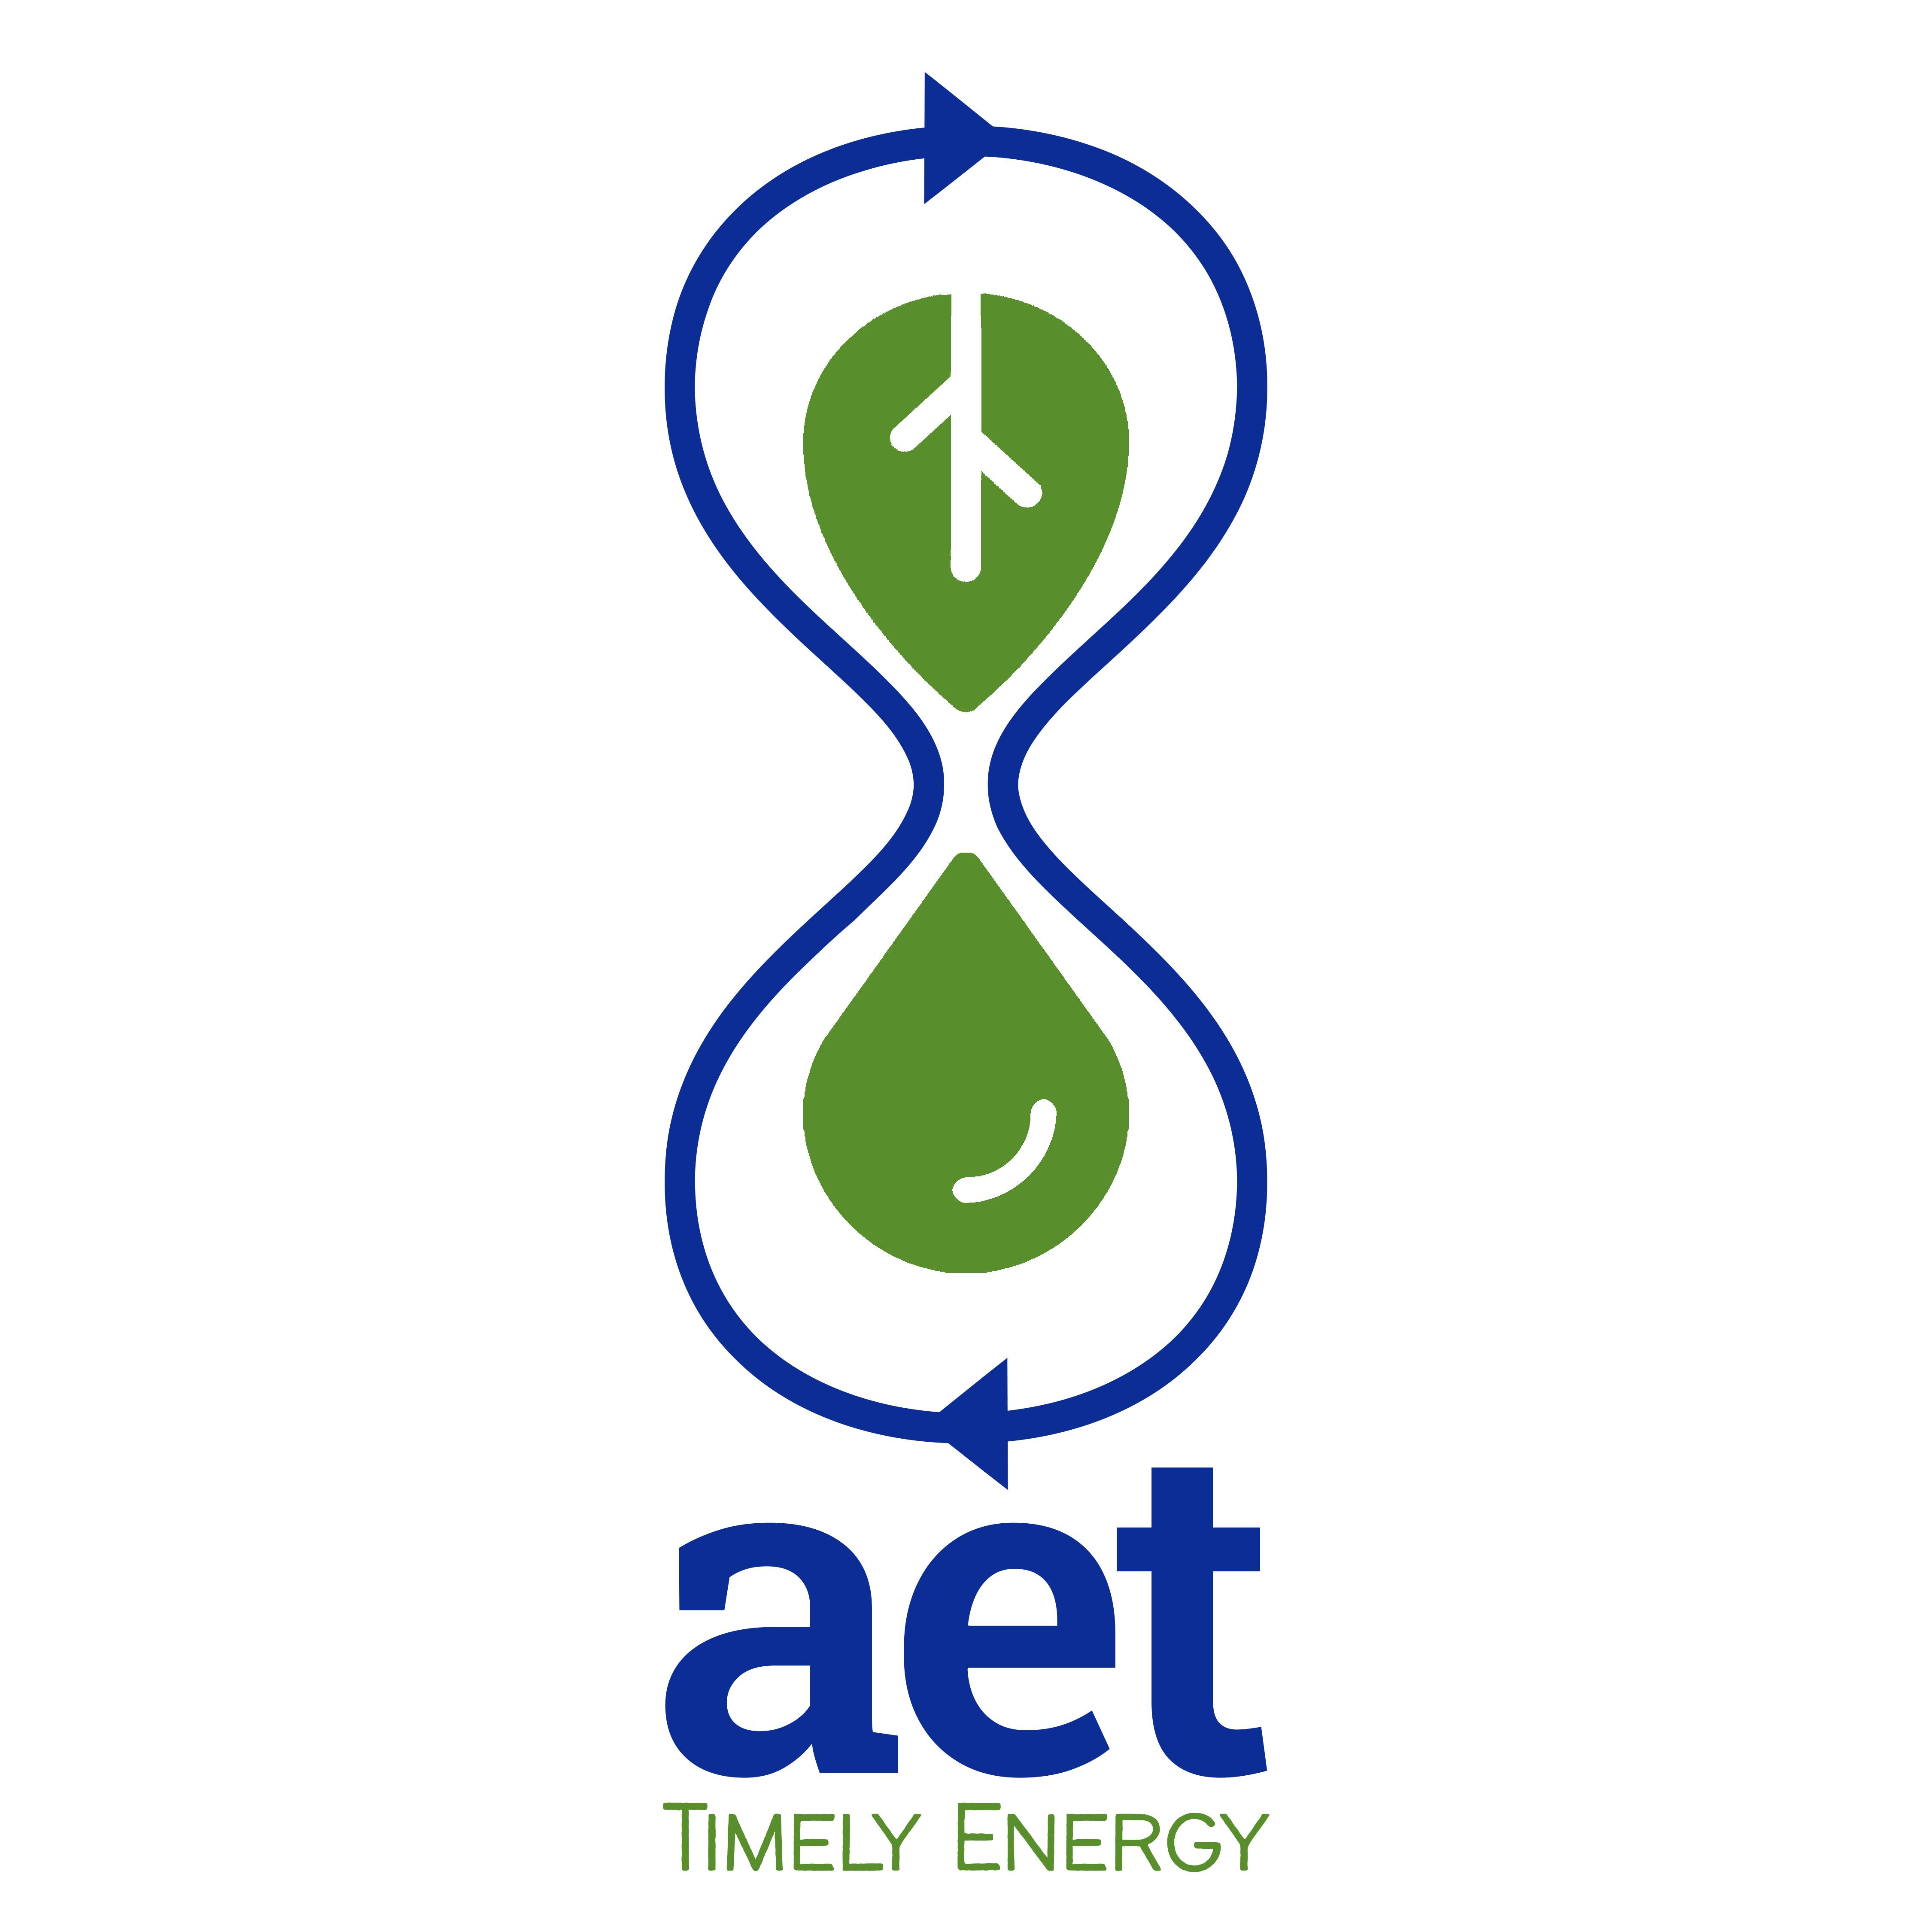
**Supported by the International Sustainability Academy (ISA)**
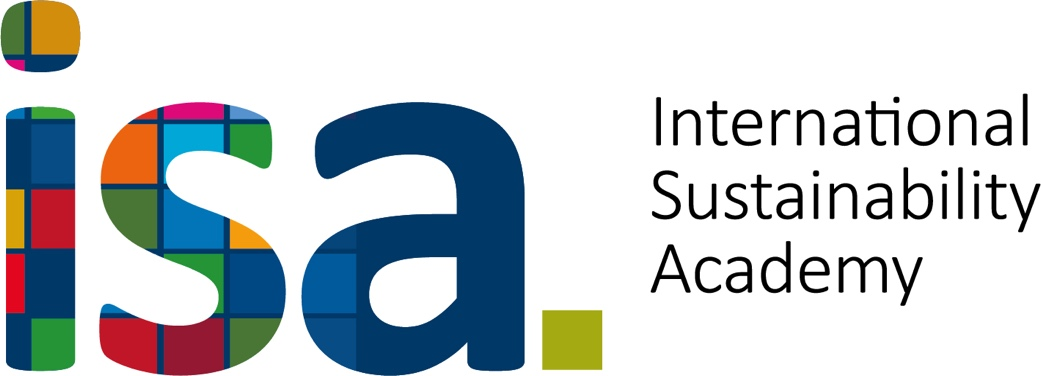